#Setup
Change these variables to edit control flow.

In [0]:
#@title Params
# run_setup = False  #@param {type:"boolean"}
# download_model = False  #@param {type:"boolean"}
restore = False  #@param {type:"boolean"}
run_training = True  #@param {type:"boolean"}
use_generated_tfrec = False #@param {type:"boolean"}
# values same as Model.TEST_MODE
mode = "TRAIN"  #@param ["TRAIN", "TEST"]  
train_iter =  1000 #@param {type:"slider", min:100, max:5000, step:100}
save_every = 1000  #@param {type:"slider", min:100, max:2000, step:10}
stop_at_loss = 0.002  #@param {type:"slider", min:0.0, max:0.01, step:0.0001}

# Dataset initialization

In [0]:
import tarfile
import shutil
import os
import time

def save_upload_model():
  model.save_model(sess, "saved_model/")
  with tarfile.open("model_%d.tar.gz"%(time.time()), "w:gz") as tar:
        tar.add("saved_model", arcname=os.path.basename("model"))
  shutil.rmtree("saved_model")

In [5]:
import tensorflow as tf
sess = tf.Session()
if tf.test.is_gpu_available():
    print("Tensorflow is able to detect gpu...")

Tensorflow is able to detect gpu...


In [0]:
from dataset_generator import get_dataset_from_generated_tfrec, normalize_n_structure_data, get_data_file_lists
from dataset_generator import get_dataset as get_file_dataset
from typing import List, Tuple

def prepare_dataset(ds: tf.data.Dataset, batch_size: int, repeat: bool):
  ds = ds.map(normalize_n_structure_data)
  if repeat:
    ds = ds.repeat()
  ds = ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
  return ds

def get_tfrec_dataset(tf_file: str, batch_size: int, repeat: bool=True) -> tf.data.Dataset:
  return prepare_dataset(get_dataset_from_generated_tfrec(tf_file), batch_size, repeat)

def get_filepath_dataset(file_list: List[Tuple[Tuple[str, str, str], Tuple[str, str, str]]], batch_size: int, repeat: bool=True)-> tf.data.Dataset:
  return prepare_dataset(get_file_dataset(file_list), batch_size, repeat)

In [9]:
if use_generated_tfrec:
  train_ds = get_tfrec_dataset('train.tfrec', batch_size=5)
  test_ds = get_tfrec_dataset('test.tfrec', batch_size=1, repeat=False)
  ktest_ds = get_tfrec_dataset('ktest.tfrec', batch_size=1, repeat=False)
else:
  train_files, test_files, ktest_files = get_data_file_lists(
      'dataset',
      4,
      ["tomato", "toothpaste"],
      ["cap_3", "food_box_3", "soda_can_2"]
  )
  train_ds = get_filepath_dataset(train_files, batch_size=5)
  test_ds = get_filepath_dataset(test_files, batch_size=1, repeat=False)
  ktest_ds = get_filepath_dataset(ktest_files, batch_size=1, repeat=False)
data_iter = tf.data.Iterator.from_structure(test_ds.output_types, test_ds.output_shapes)
simg_batch, sdepth_batch, smsk_batch, qimg_batch, qdepth_batch, qmsk_batch = data_iter.get_next()
init_training = data_iter.make_initializer(train_ds)
init_testing = data_iter.make_initializer(test_ds)
init_ktesting = data_iter.make_initializer(ktest_ds)

Instructions for updating:
Colocations handled automatically by placer.


#Model and loss function initialization

In [10]:
from model import Model
model = Model((500, 500), tf.stack([simg_batch, smsk_batch]), qimg_batch, mode=mode)
upsampled_out = tf.image.resize_bilinear(tf.expand_dims(model.output, -1), (500, 500))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [11]:
loss = tf.losses.log_loss(qmsk_batch, upsampled_out,
#                          weights=(0.91*qmsk_batch) + 0.09*(1.0-qmsk_batch))
#                           weights=(0.99*qmsk_batch) + 0.01*(1.0-qmsk_batch)) # including negatives
                          weights=(0.7*qmsk_batch) + 0.3*(1.0-qmsk_batch))
# optimizer = tf.train.AdamOptimizer(learning_rate=0.00008)
optimizer = tf.train.AdamOptimizer(learning_rate=0.000008)
train_op = optimizer.minimize(loss=loss)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


# IOU and metric functions

In [0]:
import numpy as np
from mrf_depth import improve_segmentation_with_depth

def calc_iou(pred, out):
  out_bool = out > 0.5
  pred_bool = pred > 0.5
  return np.sum( out_bool & pred_bool, axis=(1,2,3) ) / np.sum( out_bool | pred_bool, axis=(1,2,3) )
  
def measure_iou(sess, num_of_batches=-1):
  count = 0
  n = 0
  iou = 0
  iou_wd = 0
  while True:
    try:
      p, o, d = sess.run([upsampled_out, qmsk_batch, qdepth_batch])
      pwd = []
      for i in range(len(p)):
        pwd.append(improve_segmentation_with_depth(p[i][:, :, 0], d[i][:, :, 0])/255.0)
      pwd = np.expand_dims(pwd, -1)
      n += len(p)
      iou += np.sum( calc_iou(p, o) )
      iou_wd +=  np.sum( calc_iou(pwd, o) )
      count += 1
      if count == num_of_batches:
        break
    except tf.errors.OutOfRangeError:
      break
  return iou/n, iou_wd/n

# Model restore and TensorBoard Setup

In [0]:
if run_training:
#   from tensorboardcolab import TensorBoardColab

  tf.summary.scalar('loss', loss)
  tf.summary.scalar('min_prob', tf.reduce_min(model.output))
  tf.summary.scalar('max_prob', tf.reduce_max(model.output))
  tf.summary.histogram('gen_last_w', model.generator.layers[-1].weights[0])

  summary = tf.summary.merge_all()
#   tbc = TensorBoardColab()
#   sum_writer = tbc.get_writer()
  sum_writer = tf.summary.FileWriter('/content/summary/train', sess.graph)

In [14]:
sess.run(tf.global_variables_initializer())
if restore:
  model.restore_model(sess, 'model/')
else:
  model.restore_FCN32_from_ckpt(sess, './fcn32_500.ckpt')

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from model/feat/model.ckpt
INFO:tensorflow:Restoring parameters from model/gen/model.ckpt


# Training

In [0]:
if run_training:
  from tqdm import tnrange, tqdm_notebook

  sess.run(init_training)
  count = 0.0
  av_l = 0.0
  for i in tnrange(train_iter):
    s, l, _ = sess.run([summary, loss, train_op])
    sum_writer.add_summary(s, i)
    av_l += l
    count += 1
    if av_l/count <= stop_at_loss:
      print("Reached Stop loss")
      break
    if count%save_every == 0:
      print(f"Iter: {i}, Avg loss: {av_l/count}")
      count = 0.0
      av_l = 0.0
      print("Saving model...")
      save_upload_model()
  print(f"Iter: {i}, Avg loss: {av_l/count}")
  print("Saving model...")
  save_upload_model()

# Metrics and Performance

In [16]:
# %%debug
# sess.run(init_training)
# m = measure_iou(sess, 3408//5)
# print(f"Training Mean IOU: {m[0]}, using MRFs: {m[1]}")
sess.run(init_testing)
m = measure_iou(sess)
print(f"Testing Mean IOU: {m[0]}, using MRFs: {m[1]}")
sess.run(init_ktesting)
m = measure_iou(sess)
print(f"Testing (known classes) Mean IOU: {m[0]}, using MRFs: {m[1]}")

Testing Mean IOU: 0.30929759243962135, using MRFs: 0.4311022297577942
Testing (known classes) Mean IOU: 0.4996343119752295, using MRFs: 0.6629420748871441


# Output from Test Dataset

In [0]:
import matplotlib.pyplot as plt
import numpy as np

init_dataset = init_ktesting  #@param ["init_testing", "init_ktesting"] {type:"raw"}
sess.run(init_dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


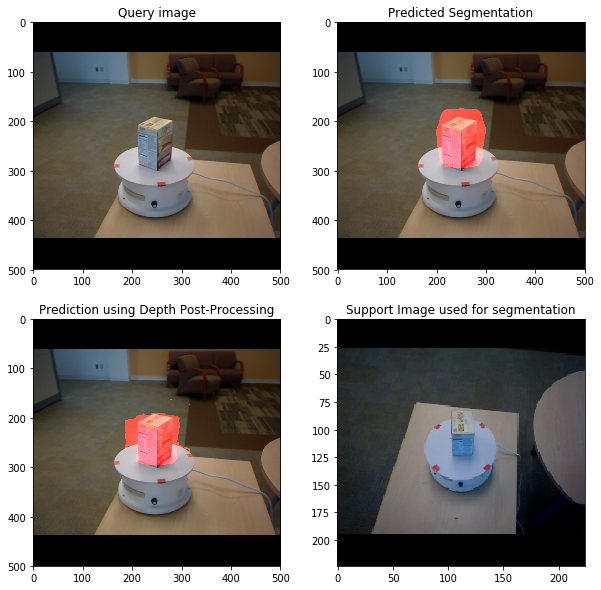

In [20]:
s, q, p, o, d = sess.run([simg_batch, qimg_batch, upsampled_out, qmsk_batch, qdepth_batch])
im_o = improve_segmentation_with_depth(p[0][:, :, 0], d[0][:, :, 0])

fig = plt.figure(figsize=(10, 10))
fig.add_subplot(2, 2, 1)
im = (q[0,:,:,:]+1.0)/2.0
plt.title('Query image')
plt.imshow(im)
im1 = np.copy(im)
im1[:, :, 0] += p[0,:,:,0]>0.6
fig.add_subplot(2, 2, 2)
plt.title('Predicted Segmentation')
plt.imshow(im1)
# im[:,:, 0] += o[0,:, :, 0]
im[:,:, 0] += im_o
fig.add_subplot(2, 2, 3)
plt.title('Prediction using Depth Post-Processing')
plt.imshow(im)
fig.add_subplot(2, 2, 4)
plt.title('Support Image used for segmentation')
plt.imshow((s[0]+1.0)/2.0)